# Задание 3

In [1]:
!pip install -q catalyst

     |████████████████████████████████| 512kB 6.5MB/s 
     |████████████████████████████████| 122kB 9.5MB/s 
     |████████████████████████████████| 645kB 10.0MB/s 


In [2]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [3]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [4]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

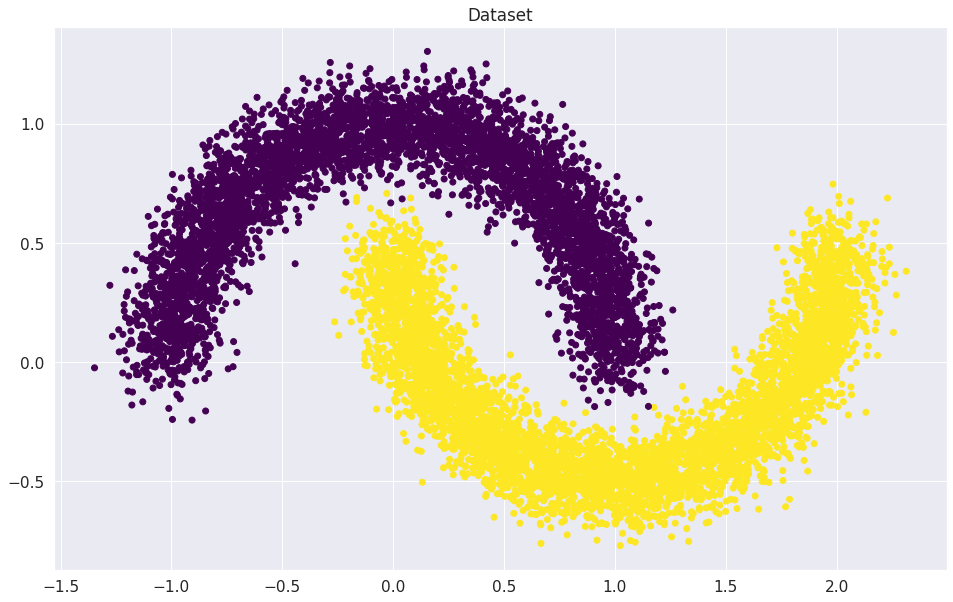

In [5]:
%matplotlib inline

plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [7]:
X_train_t =  torch.FloatTensor(X_train) 
y_train_t = torch.FloatTensor(y_train) 
X_val_t =  torch.FloatTensor(X_val) 
y_val_t =  torch.FloatTensor(y_val) 

Создаем `Dataset` и `DataLoader`. 

In [8]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
linear_regression.to(device)
loss_function = nn.BCEWithLogitsLoss() # https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [12]:
!pip install torch-summary

In [13]:
from torchsummary import summary

summary(linear_regression)

Layer (type:depth-idx)                   Param #
└─LinearRegression: 0-1                  3
Total params: 3
Trainable params: 3
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
└─LinearRegression: 0-1                  3
Total params: 3
Trainable params: 3
Non-trainable params: 0

In [14]:
# из комментариев

def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(linear_regression)

3

In [15]:
# из решений

!pip install torchinfo

from torchinfo import summary

model_info = summary(linear_regression)
print('Обучаемых параметров у получившейся модели:', model_info.trainable_params)

Обучаемых параметров у получившейся модели: 3


**Вопрос 1** Сколько обучаемых параметров у получившейся модели?

**Ответ:** 3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [17]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    utils.set_global_seed(42 + epoch) # random.seed
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch.to(device))
        loss = loss_function(outp, torch.unsqueeze(y_batch, dim=1).to(device)) # добавляем размерность 1, чтобы было как в outp - torch.Size([128, 1])
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        sigm =  nn.Sigmoid()
        probabilities =  sigm(outp)
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch.to(device)).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5859375
Iteration: 7500
Batch accuracy: 0.765625
Iteration: 15000
Batch accuracy: 0.7890625
Iteration: 22500
Batch accuracy: 0.7890625
Iteration: 30000
Batch accuracy: 0.8046875
Iteration: 37500
Batch accuracy: 0.8046875
Iteration: 45000
Batch accuracy: 0.8046875
Iteration: 52500
Batch accuracy: 0.8203125
Iteration: 60000
Batch accuracy: 0.8203125
Iteration: 67500
Batch accuracy: 0.8203125
Iteration: 75000
Batch accuracy: 0.8203125
Iteration: 82500
Batch accuracy: 0.8203125
Iteration: 90000
Batch accuracy: 0.8203125

Iteration: 90047.Convergence. Stopping iterations.


**Вопрос 2**

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 90047

### Визуализируем результаты

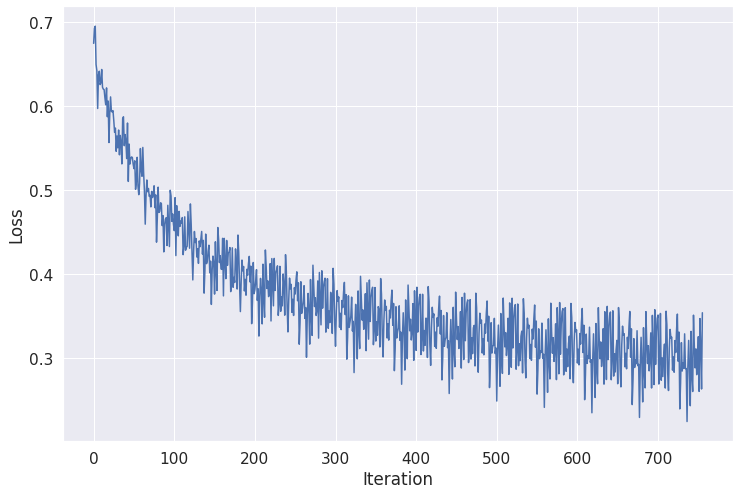

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

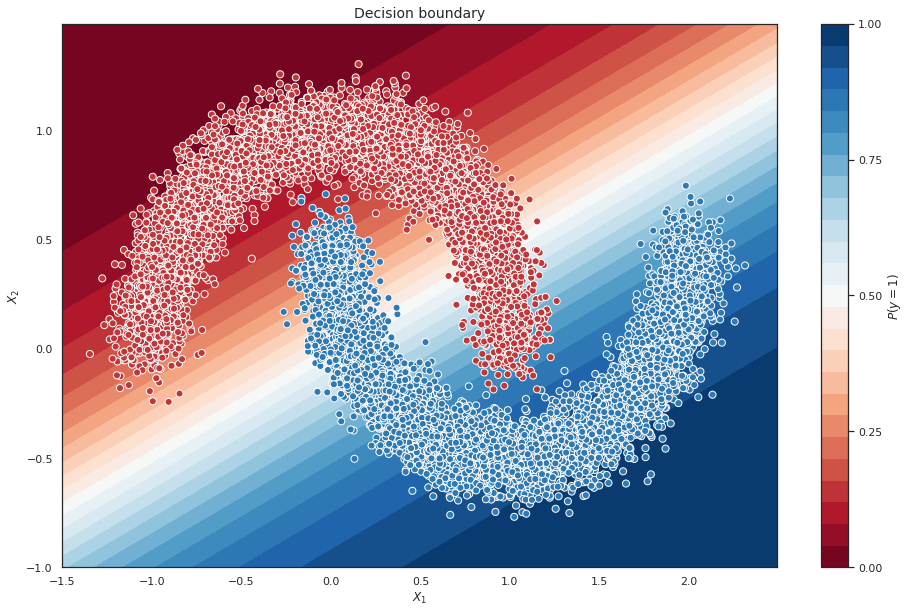

In [21]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch.to(device)).reshape(xx.shape))
    probs = probs.cpu().numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [26]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch.to(device))
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.cpu().numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [27]:
from sklearn.metrics import accuracy_score

val_preds = predict(val_dataloader, linear_regression)
accuracy_score(y_val_t, val_preds)

0.862

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:**  0.862

### MNIST

In [28]:
import os
from catalyst.contrib.datasets import MNIST
from torchvision import transforms

In [29]:
transform = transforms.Compose(
    [transforms.ToTensor()])

train_dataset = MNIST(root=os.getcwd(), train=True, download=True, transform=transform)
val_dataset = MNIST(root=os.getcwd(), train=False, transform=transform)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.7/dist-packages/catalyst/contrib/datasets/functional.py:187: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [30]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

In [45]:
# no activation
# activation = nn.ReLU
# activation = nn.LeakyReLU
activation = nn.ELU

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

model.to(device)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [47]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp =  model(x_batch.to(device))
            else:
                 model.eval()
                 with torch.no_grad(): 
                    outp = model(x_batch.to(device))
            preds = outp.argmax(-1) # классы с максимальной вероятностью
            correct = (preds.flatten() == y_batch.to(device)).type(torch.float32).sum() 
            all = y_batch.size(0)
            epoch_correct += correct.item() # Переводим тензор в скаляр
            epoch_all += all
            if k == "train":
                 loss = criterion(outp, y_batch.to(device))   
                 loss.backward()
                 optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8895833333333333
Loader: valid. Accuracy: 0.8951571428571429
Epoch: 2
Loader: train. Accuracy: 0.9433166666666667
Loader: valid. Accuracy: 0.9443428571428572
Epoch: 3
Loader: train. Accuracy: 0.9596
Loader: valid. Accuracy: 0.9599
Epoch: 4
Loader: train. Accuracy: 0.9693833333333334
Loader: valid. Accuracy: 0.9691285714285715
Epoch: 5
Loader: train. Accuracy: 0.97535
Loader: valid. Accuracy: 0.9745857142857143
Epoch: 6
Loader: train. Accuracy: 0.9801666666666666
Loader: valid. Accuracy: 0.9788142857142857
Epoch: 7
Loader: train. Accuracy: 0.9839333333333333
Loader: valid. Accuracy: 0.9819714285714286
Epoch: 8
Loader: train. Accuracy: 0.9871833333333333
Loader: valid. Accuracy: 0.9848
Epoch: 9
Loader: train. Accuracy: 0.9896166666666667
Loader: valid. Accuracy: 0.987
Epoch: 10
Loader: train. Accuracy: 0.9920166666666667
Loader: valid. Accuracy: 0.9893857142857143


Попробуйте разные функции активации. Позапускайте ячейки сверху несколько раз изменив функции активации. После каждого обучения запустите одну из ячеек снизу. Таким образом мы получим график accuracy/epoch для каждой функции активации.

In [36]:
plain_accuracy = accuracy["valid"]
plain_accuracy

[0.8850428571428571,
 0.9112428571428571,
 0.9148,
 0.9168428571428572,
 0.9181857142857143,
 0.9191857142857143,
 0.9201714285714285,
 0.9208142857142857,
 0.9213571428571429,
 0.9217571428571428]

In [40]:
relu_accuracy = accuracy["valid"]
relu_accuracy

[0.8916142857142857,
 0.9478714285714286,
 0.9628428571428571,
 0.9711428571428572,
 0.9773571428571428,
 0.9820857142857143,
 0.9857857142857143,
 0.9878714285714286,
 0.9891857142857143,
 0.9901428571428571]

In [44]:
leaky_relu_accuracy = accuracy["valid"]
leaky_relu_accuracy

[0.8912428571428571,
 0.9491,
 0.9636,
 0.9719285714285715,
 0.9779285714285715,
 0.9829285714285714,
 0.9856428571428572,
 0.9878,
 0.9894428571428572,
 0.9903857142857143]

In [48]:
elu_accuracy = accuracy["valid"]
elu_accuracy

[0.8951571428571429,
 0.9443428571428572,
 0.9599,
 0.9691285714285715,
 0.9745857142857143,
 0.9788142857142857,
 0.9819714285714286,
 0.9848,
 0.987,
 0.9893857142857143]

### Accuracy

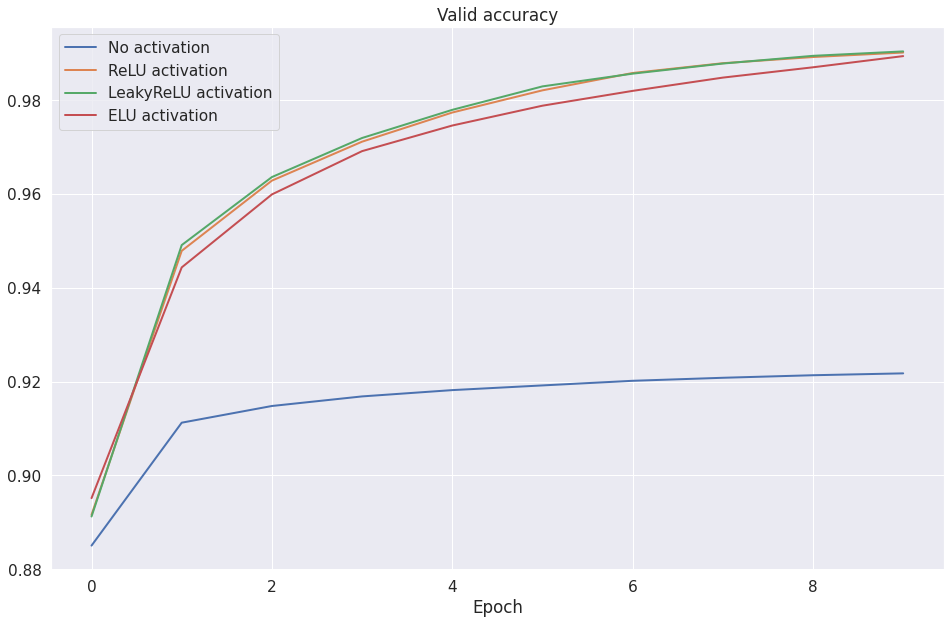

In [49]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

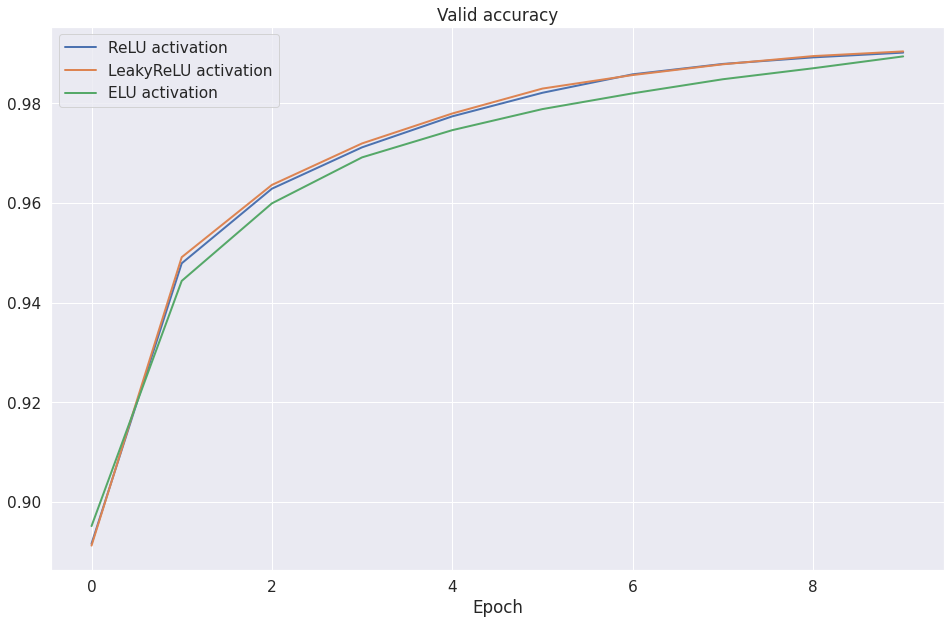

In [50]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4** Какая из активаций показала наивысший `accuracy`?

**Ответ:** LeakyReLU, хотя ответ на Степик говорит, что ReLU

## Сверточные слои

### Ядра

In [51]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-05-08 06:38:00--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-05-08 06:38:01--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   207KB/s    in 0.2s    

2021-05-08 06:38:01 (207 KB/s) - ‘sample_photo.jpg’ saved [49337/4

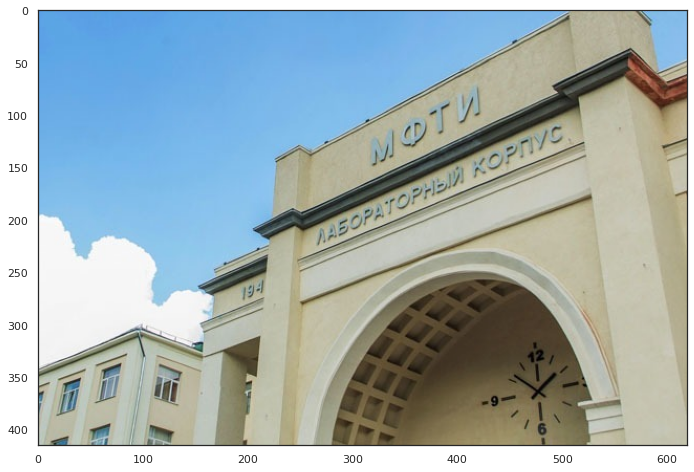

In [52]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [53]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


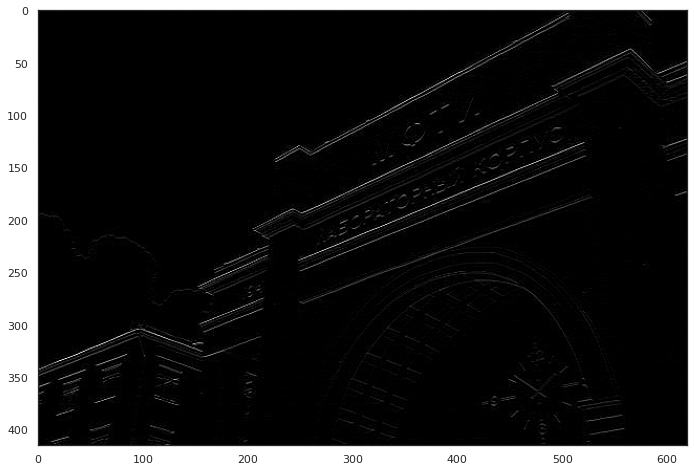

In [54]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5** Как вы считаете, как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** А - 3, Б - 5, В - 4, Г - 6, Д - 2, Е - 1. На Степик ответы Б и В поменяны местами.

### LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Давайте посмотрим на архитектуру, предложенную еще в 1998 году!

In [55]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0])) # x.nelement() - возвращает общее количество элементов input тензора, x.shape[0] - размер батча
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [56]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [57]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42+epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp =  model(x_batch.to(device))
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device))
                    # outp = model(x_batch.type(torch.float32).unsqueeze(1).to(device))
            preds = outp.argmax(-1)
            correct = (preds.flatten() == y_batch.to(device)).type(torch.float32).sum() 
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.85205
Loader: valid. Accuracy: 0.8665142857142857
Epoch: 2
Loader: train. Accuracy: 0.9583166666666667
Loader: valid. Accuracy: 0.9598428571428571
Epoch: 3
Loader: train. Accuracy: 0.9711
Loader: valid. Accuracy: 0.9717285714285714
Epoch: 4
Loader: train. Accuracy: 0.9777166666666667
Loader: valid. Accuracy: 0.978
Epoch: 5
Loader: train. Accuracy: 0.98185
Loader: valid. Accuracy: 0.9819142857142857
Epoch: 6
Loader: train. Accuracy: 0.98475
Loader: valid. Accuracy: 0.9843857142857143
Epoch: 7
Loader: train. Accuracy: 0.9866666666666667
Loader: valid. Accuracy: 0.9860857142857142
Epoch: 8
Loader: train. Accuracy: 0.9888666666666667
Loader: valid. Accuracy: 0.9879142857142857
Epoch: 9
Loader: train. Accuracy: 0.9903333333333333
Loader: valid. Accuracy: 0.9893
Epoch: 10
Loader: train. Accuracy: 0.9917
Loader: valid. Accuracy: 0.9907142857142858


In [58]:
lenet_accuracy = accuracy["valid"]
np.array(lenet_accuracy).mean()

0.9696400000000001

Сравним с предыдущем пунктом

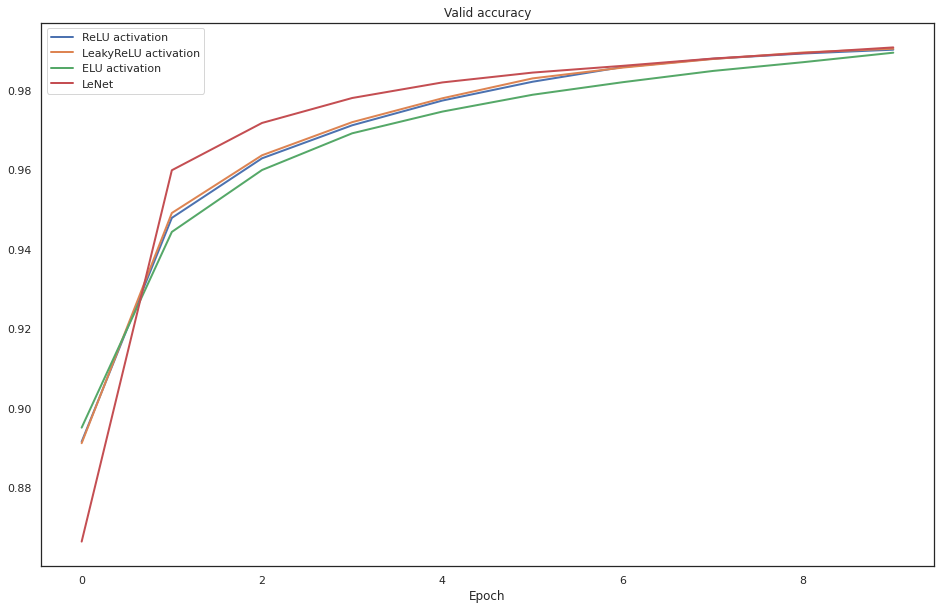

In [59]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.97